In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
uom190346a_sleep_health_and_lifestyle_dataset_path = kagglehub.dataset_download('uom190346a/sleep-health-and-lifestyle-dataset')

print('Data source import complete.')


Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sleep-health-and-lifestyle-dataset/Sleep_health_and_lifestyle_dataset.csv


# Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder ,RobustScaler,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold,cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import xgboost as xgb


# Reading CSV data

In [ ]:
df = pd.read_csv('/kaggle/input/sleep-health-and-lifestyle-dataset/Sleep_health_and_lifestyle_dataset.csv')

# EDA

In [ ]:
df.head(5)

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [ ]:
df.shape

(374, 13)

In [ ]:
df.dtypes

,0
Person ID,int64
Gender,object
Age,int64
Occupation,object
Sleep Duration,float64
Quality of Sleep,int64
Physical Activity Level,int64
Stress Level,int64
BMI Category,object
Blood Pressure,object


In [ ]:
df.describe()

,Person ID,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,187.500000,42.184492,7.132086,7.312834,59.171123,5.385027,70.165775,6816.844920
std,108.108742,8.673133,0.795657,1.196956,20.830804,1.774526,4.135676,1617.915679
min,1.000000,27.000000,5.800000,4.000000,30.000000,3.000000,65.000000,3000.000000
25%,94.250000,35.250000,6.400000,6.000000,45.000000,4.000000,68.000000,5600.000000
50%,187.500000,43.000000,7.200000,7.000000,60.000000,5.000000,70.000000,7000.000000
75%,280.750000,50.000000,7.800000,8.000000,75.000000,7.000000,72.000000,8000.000000
max,374.000000,59.000000,8.500000,9.000000,90.000000,8.000000,86.000000,10000.000000


In [ ]:
columns = [column for column in df.columns if column!='Person ID']

In [ ]:
for column in columns:
    unique_values = df[column].unique()
    print(f"Unique values in '{column}': {unique_values}")

Unique values in 'Gender': ['Male' 'Female']
Unique values in 'Age': [27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 48 49 50 51 52
 53 54 55 56 57 58 59]
Unique values in 'Occupation': ['Software Engineer' 'Doctor' 'Sales Representative' 'Teacher' 'Nurse'
 'Engineer' 'Accountant' 'Scientist' 'Lawyer' 'Salesperson' 'Manager']
Unique values in 'Sleep Duration': [6.1 6.2 5.9 6.3 7.8 6.  6.5 7.6 7.7 7.9 6.4 7.5 7.2 5.8 6.7 7.3 7.4 7.1
 6.6 6.9 8.  6.8 8.1 8.3 8.5 8.4 8.2]
Unique values in 'Quality of Sleep': [6 4 7 5 8 9]
Unique values in 'Physical Activity Level': [42 60 30 40 75 35 45 50 32 70 80 55 90 47 65 85]
Unique values in 'Stress Level': [6 8 7 4 3 5]
Unique values in 'BMI Category': ['Overweight' 'Normal' 'Obese' 'Normal Weight']
Unique values in 'Blood Pressure': ['126/83' '125/80' '140/90' '120/80' '132/87' '130/86' '117/76' '118/76'
 '128/85' '131/86' '128/84' '115/75' '135/88' '129/84' '130/85' '115/78'
 '119/77' '121/79' '125/82' '135/90' '122/80' '142/92' '140/95

In [ ]:
# Replace NaN in 'Sleep Disorder' with 'No Disorder'
df['Sleep Disorder'].fillna('No Disorder', inplace=True)


In [ ]:
# Value counts of 'Sleep Disorder'
sleep_disorder_counts = df['Sleep Disorder'].value_counts()

print("Value counts of 'Sleep Disorder':")
print(sleep_disorder_counts)

Value counts of 'Sleep Disorder':
Sleep Disorder
No Disorder    219
Sleep Apnea     78
Insomnia        77
Name: count, dtype: int64


In [ ]:
df['BMI Category']=df['BMI Category'].replace({'Normal':'Normal Weight'})
df['BMI Category'].value_counts()

,count
BMI Category,
Normal Weight,216
Overweight,148
Obese,10


In [ ]:
# bmi_counts = df['BMI Category'].value_counts()
fig = px.histogram(data_frame=df, x = 'BMI Category', color = 'Sleep Disorder', title='Bar Chart of BMI Category Counts')
fig.show()


- Obese suffer from Insomnia and Sleep Apnea
- Very few overweighted people have no sleep disorder
- Very few people of normal weight face sleep disorder

In [ ]:
fig = px.histogram(data_frame=df, x = 'Quality of Sleep', color = 'Sleep Disorder', title='Bar Chart of BMI Category Counts')
fig.show()

In [ ]:
fig = px.histogram(data_frame=df, x = 'Occupation', color = 'Sleep Disorder', title='Bar Chart of BMI Category Counts')
fig.show()

Occupation of Nurse,Teacher, Sales person and sales representative are prone to sleep disorder

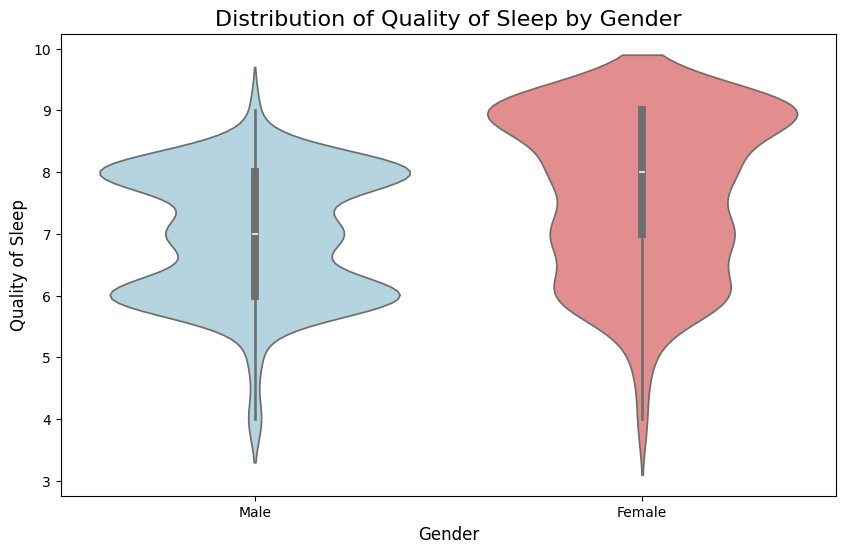

In [ ]:
color_palette = {'Male': 'lightblue', 'Female': 'lightcoral'}
plt.figure(figsize=(10, 6))
sns.violinplot(x='Gender', y='Quality of Sleep', data=df, palette=color_palette)
plt.title('Distribution of Quality of Sleep by Gender', fontsize=16)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Quality of Sleep', fontsize=12)
plt.show()

In [ ]:
fig = px.bar(df,
             x='Stress Level',
             y='Quality of Sleep',
             color='Stress Level',
             title='Relationship between Stress Level and Quality of Sleep'
            )
fig.show()

**Splitting Blood Pressure into two columns: Systolic and Diastolic**

In [ ]:
df = pd.concat([df, df['Blood Pressure'].str.split('/', expand=True)], axis=1).drop('Blood Pressure', axis=1)
df = df.rename(columns={0: 'Systolic', 1: 'Diastolic'})

In [ ]:
df['Systolic'] = df['Systolic'].astype(float)
df['Diastolic'] = df['Diastolic'].astype(float)

In [ ]:
numeric_features = ['Age', 'Sleep Duration',
                    'Physical Activity Level',
                    'Heart Rate', 'Daily Steps', 'Systolic', 'Diastolic']

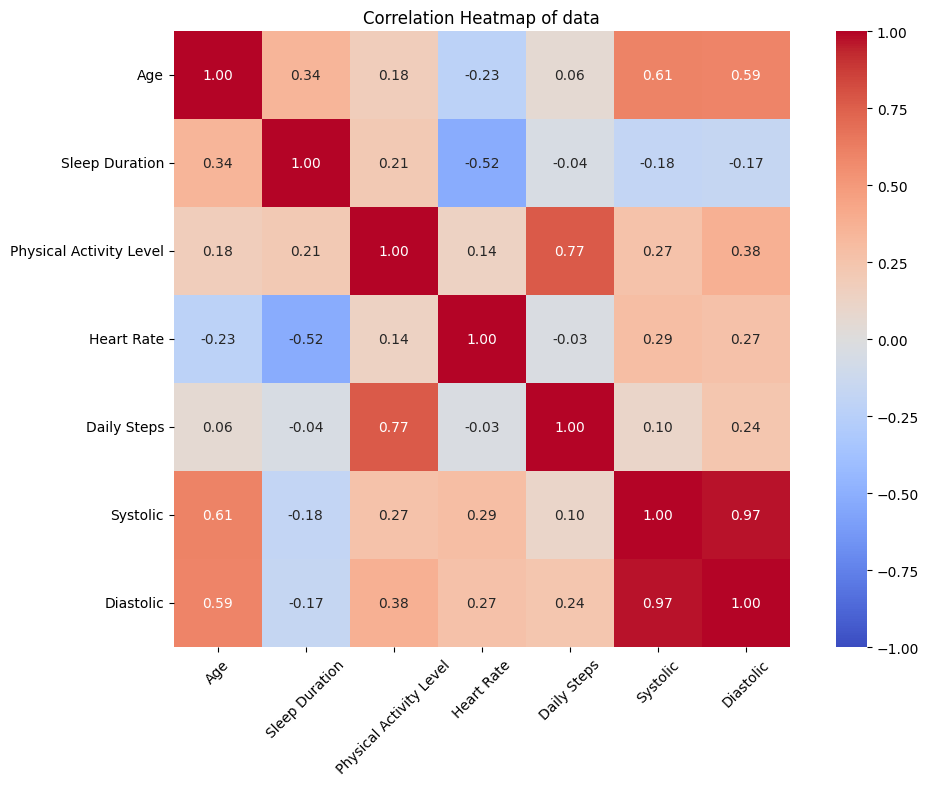

In [ ]:
# Calculate the correlation matrix
corr_matrix = df[numeric_features].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw the heatmap without the mask
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, square=True)

# Customize plot labels and title
plt.title('Correlation Heatmap of data')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Show plot
plt.show()


In [ ]:
df.drop(columns=['Person ID'],inplace = True)

In [ ]:
label_encoder = LabelEncoder()
df['Sleep Disorder'] = label_encoder.fit_transform(df['Sleep Disorder'])

In [ ]:
print(label_encoder.classes_)

['Insomnia' 'No Disorder' 'Sleep Apnea']


# Preprocessing

In [ ]:
numeric_features = ['Age', 'Sleep Duration',
                    'Heart Rate', 'Daily Steps', 'Systolic', 'Diastolic']

categorical_features = ['Occupation','Quality of Sleep','Gender',
                    'Physical Activity Level', 'Stress Level', 'BMI Category']


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first',sparse_output =False, handle_unknown='ignore'), categorical_features)
    ])

In [ ]:
X = df.drop(columns=['Sleep Disorder'])
y = df['Sleep Disorder']

In [ ]:
X_preprocessed = preprocessor.fit_transform(X)

# Handling Imbalance Data - SMOTE

In [ ]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Perform SMOTE oversampling
X_smote, y_smote = smote.fit_resample(X_preprocessed, y)
X_smote.shape

(657, 44)

In [ ]:
# Splitting the data into training and testing sets (e.g., 75% training, 25% testing)
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.25, random_state=42)

# Model Training

> Logistic Regression

Accuracy: 0.9090909090909091
Precision: 0.910767756617559
Recall: 0.9090909090909091
F1-score: 0.9084234273263183
              precision    recall  f1-score   support

           0       0.94      0.82      0.87        38
           1       0.88      0.95      0.92        64
           2       0.92      0.92      0.92        63

    accuracy                           0.91       165
   macro avg       0.91      0.90      0.90       165
weighted avg       0.91      0.91      0.91       165

Confusion Matrix:
[[31  3  4]
 [ 2 61  1]
 [ 0  5 58]]


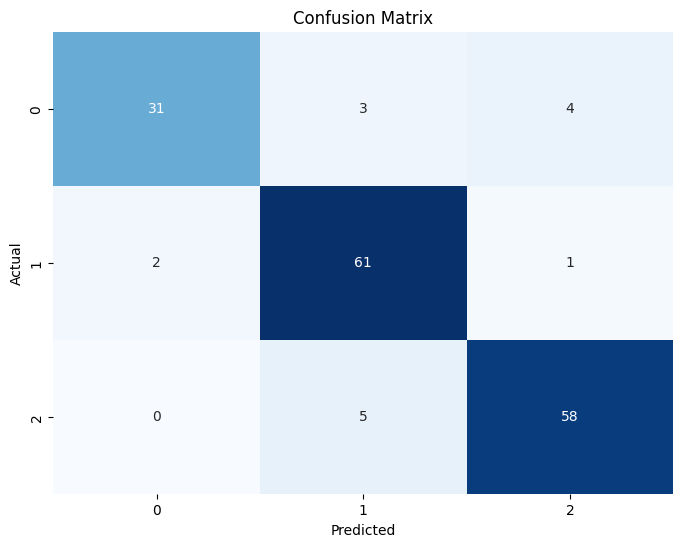

In [ ]:

# Initialize Logistic Regression classifier
model_lr = LogisticRegression()

# Fit the model on the training data
model_lr.fit(X_train, y_train)

# Predict on the test data
y_pred_lr = model_lr.predict(X_test)

# Calculate evaluation metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
recall_lr = recall_score(y_test, y_pred_lr, average='weighted')
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

# Print metrics
print(f'Accuracy: {accuracy_lr}')
print(f'Precision: {precision_lr}')
print(f'Recall: {recall_lr}')
print(f'F1-score: {f1_lr}')

# Generate classification report
print(classification_report(y_test, y_pred_lr))

# Generate confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
print('Confusion Matrix:')
print(cm_lr)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


> XGB Classifier

Accuracy: 0.9272727272727272
Precision: 0.9287307861220904
Recall: 0.9272727272727272
F1-score: 0.9271254483064495
              precision    recall  f1-score   support

           0       0.92      0.87      0.89        38
           1       0.90      0.97      0.93        64
           2       0.97      0.92      0.94        63

    accuracy                           0.93       165
   macro avg       0.93      0.92      0.92       165
weighted avg       0.93      0.93      0.93       165

Confusion Matrix:
[[33  3  2]
 [ 2 62  0]
 [ 1  4 58]]


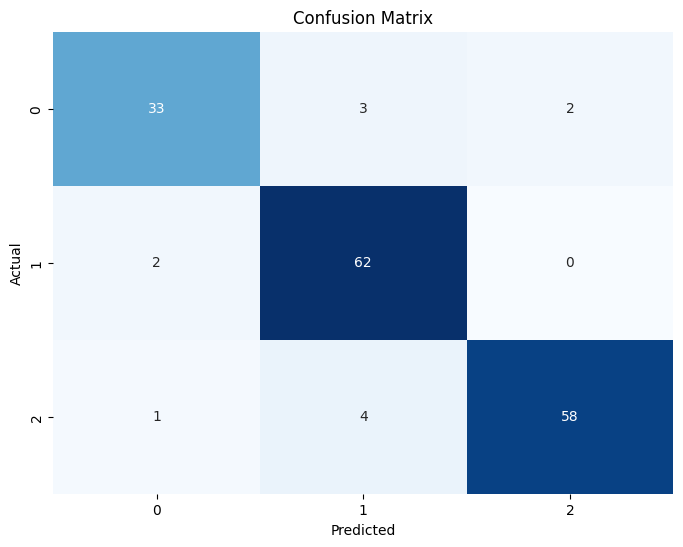

In [ ]:
# Initialize XGBoost classifier (assuming classification task)
model_xgb = xgb.XGBClassifier()

# Fit the model on the training data
model_xgb.fit(X_train, y_train)

# Predict on the test data
y_pred = model_xgb.predict(X_test)
# Calculate evaluation metrics
accuracy_xgb = accuracy_score(y_test, y_pred)
precision_xgb = precision_score(y_test, y_pred, average='weighted')
recall_xgb = recall_score(y_test, y_pred, average='weighted')
f1_xgb = f1_score(y_test, y_pred, average='weighted')

# Print metrics
print(f'Accuracy: {accuracy_xgb}')
print(f'Precision: {precision_xgb}')
print(f'Recall: {recall_xgb}')
print(f'F1-score: {f1_xgb}')

# Generate classification report
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


> Cross Eval XGB Model

In [ ]:
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(xgb_model, X_smote, y_smote, cv=cv, scoring='accuracy')

In [ ]:
scores

array([0.92424242, 0.89393939, 0.93129771, 0.9389313 , 0.92366412])

> Gradient Boosting Classifier

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86        38
           1       0.90      0.97      0.93        64
           2       0.95      0.90      0.93        63

    accuracy                           0.92       165
   macro avg       0.91      0.91      0.91       165
weighted avg       0.92      0.92      0.91       165



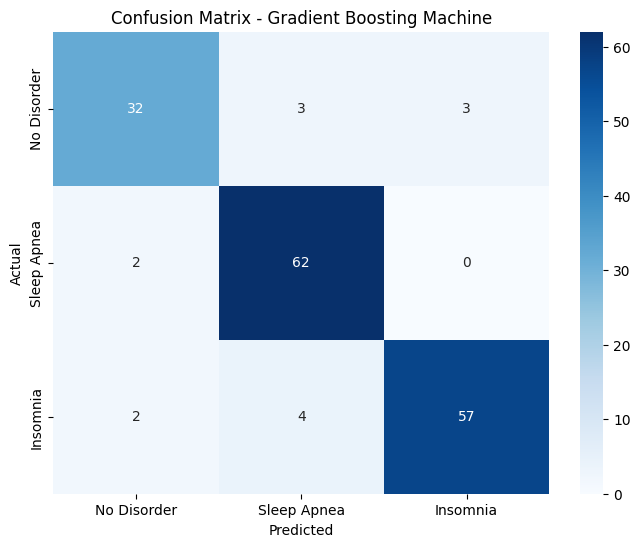

Accuracy: 0.9152
Precision: 0.9160
Recall: 0.9152
F1 Score: 0.9147


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize GBM classifier
gbm_clf = GradientBoostingClassifier(random_state=42)

# Train the model
gbm_clf.fit(X_train, y_train)

# Predictions
y_pred = gbm_clf.predict(X_test)

# Calculate metrics
accuracy_gbm = accuracy_score(y_test, y_pred)
precision_gbm = precision_score(y_test, y_pred, average='weighted')
recall_gbm = recall_score(y_test, y_pred, average='weighted')
f1_gbm = f1_score(y_test, y_pred, average='weighted')

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['No Disorder', 'Sleep Apnea', 'Insomnia'], yticklabels=['No Disorder', 'Sleep Apnea', 'Insomnia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Gradient Boosting Machine')
plt.show()

# Display metrics
print(f"Accuracy: {accuracy_gbm:.4f}")
print(f"Precision: {precision_gbm:.4f}")
print(f"Recall: {recall_gbm:.4f}")
print(f"F1 Score: {f1_gbm:.4f}")



> K Neighbors Classifier

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86        38
           1       0.91      0.91      0.91        64
           2       0.97      0.92      0.94        63

    accuracy                           0.91       165
   macro avg       0.90      0.91      0.90       165
weighted avg       0.91      0.91      0.91       165



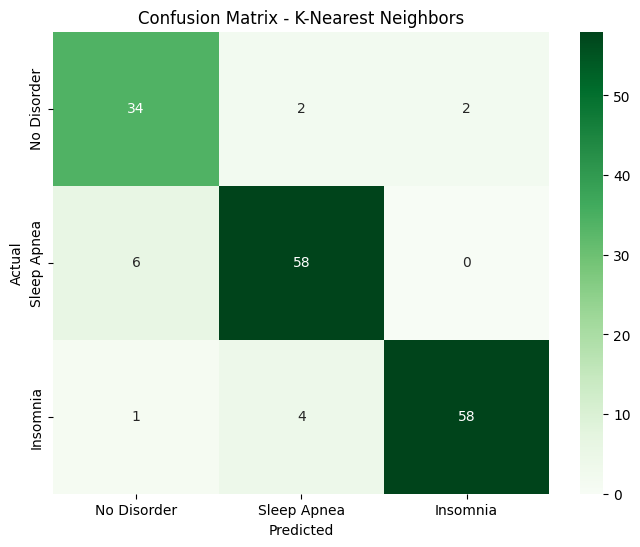

Accuracy: 0.9091
Precision: 0.9116
Recall: 0.9091
F1 Score: 0.9098


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize KNN classifier (example using k=5)
knn_clf = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn_clf.fit(X_train, y_train)

# Predictions
y_pred = knn_clf.predict(X_test)

# Calculate metrics
accuracy_knn = accuracy_score(y_test, y_pred)
precision_knn = precision_score(y_test, y_pred, average='weighted')
recall_knn = recall_score(y_test, y_pred, average='weighted')
f1_knn = f1_score(y_test, y_pred, average='weighted')

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Greens', fmt='d', xticklabels=['No Disorder', 'Sleep Apnea', 'Insomnia'], yticklabels=['No Disorder', 'Sleep Apnea', 'Insomnia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - K-Nearest Neighbors')
plt.show()

# Display metrics
print(f"Accuracy: {accuracy_knn:.4f}")
print(f"Precision: {precision_knn:.4f}")
print(f"Recall: {recall_knn:.4f}")
print(f"F1 Score: {f1_knn:.4f}")

# Model Comparison

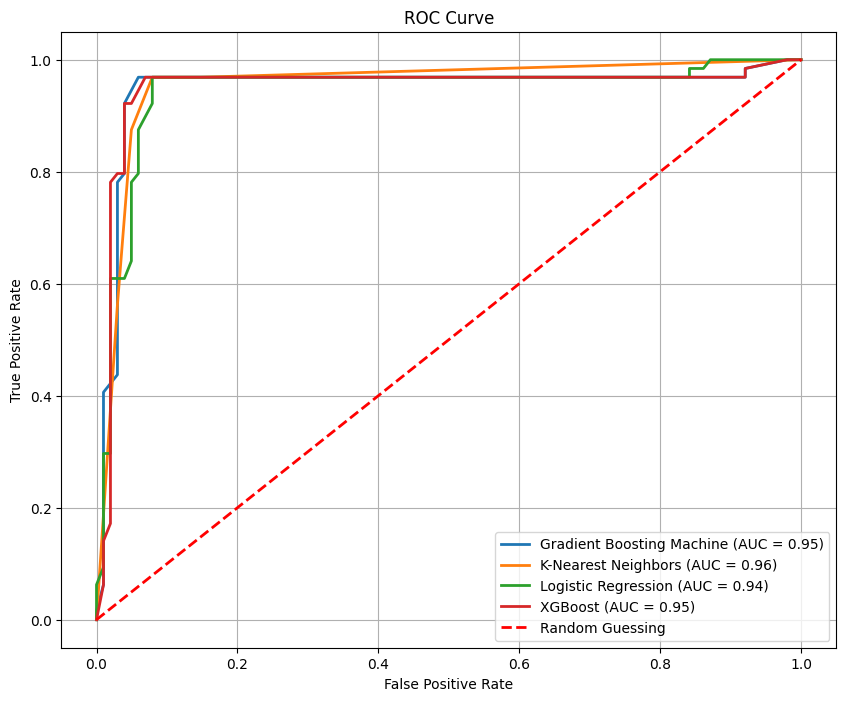

In [ ]:
from sklearn.metrics import roc_curve, auc

# Initialize figure
fig_roc = plt.figure(figsize=(10, 8))
models = ['Gradient Boosting Machine', 'K-Nearest Neighbors', 'Logistic Regression', 'XGBoost']

# Plot ROC curve for each model
for idx, model in enumerate([gbm_clf, knn_clf, model_lr, model_xgb]):
    if model == knn_clf:
        y_scores = model.predict_proba(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_scores[:, 1], pos_label=1)
    else:
        y_scores = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_scores, pos_label=1)

    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{models[idx]} (AUC = {roc_auc:.2f})')

# Plot ROC curve for random guessing
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random Guessing')

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()

# Show plot
plt.show()


# Saving Model

In [ ]:
import pickle
with open("Model_Prediction.sav", "wb") as f:
    pickle.dump(model_xgb,f)

In [ ]:
with open('preprocessor.sav', 'wb') as f:
    pickle.dump(preprocessor, f)

In [ ]:


# # Load the saved model
# model_xgb = joblib.load('model_xgb.pkl')

# # Load label encoders for categorical variables
# label_encoder = LabelEncoder()

# # Function to handle user input
# def get_user_input():
#     # Example user input (you can modify this based on your actual input method)
#     user_data = {}

#     # Accepting user input dynamically
#     print("Please enter the following information:")

#     user_data['Gender'] = input("Gender (Male/Female): ").strip()
#     user_data['Age'] = int(input("Age: ").strip())
#     user_data['Occupation'] = input("Occupation: ").strip()
#     user_data['Sleep Duration'] = int(input("Sleep Duration (hours): ").strip())
#     user_data['Quality of Sleep'] = int(input("Quality of Sleep (1-10): ").strip())
#     user_data['Physical Activity Level'] = int(input("Physical Activity Level (minutes): ").strip())
#     user_data['Stress Level'] = int(input("Stress Level (1-10): ").strip())
#     user_data['BMI Category'] = input("BMI Category: ").strip()
#     user_data['Blood Pressure'] = input("Blood Pressure (Systolic/Diastolic): ").strip()
#     user_data['Heart Rate'] = int(input("Heart Rate (bpm): ").strip())
#     user_data['Daily Steps'] = int(input("Daily Steps: ").strip())

#     # Convert user input to DataFrame for consistency
#     user_df = pd.DataFrame([user_data])

#     # Apply label encoding to categorical columns
#     cat_cols=['Gender','Occupation','BMI Category']
#     for col in cat_cols:
#         user_df[col] = label_encoder.fit_transform(user_df[col])

#     # Split the 'Blood Pressure' column into two columns
#     user_df[['Systolic BP', 'Diastolic BP']] = user_df['Blood Pressure'].str.split('/', expand=True)

#     # Convert the new columns to numeric type
#     user_df[['Systolic BP', 'Diastolic BP']] = user_df[['Systolic BP', 'Diastolic BP']].apply(pd.to_numeric)

#     # Drop the original 'Blood Pressure' column
#     user_df = user_df.drop('Blood Pressure', axis=1)

#     return user_df

# # Get user input
# user_df = get_user_input()

# # Predict sleep disorder class
# predicted_class = model_xgb.predict(user_df)

# # Map numerical prediction back to original classes
# sleep_disorder_map = {0: 'No Disorder', 1: 'Sleep Apnea', 2: 'Insomnia'}
# predicted_class_label = sleep_disorder_map[predicted_class[0]]

# print(f"Predicted Sleep Disorder: {predicted_class_label}")
